Columns Understanding ¶
Type: consisting of a letter L, M, or H for low, medium and high as product quality variants.

air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.

process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise.

torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.

tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

machine failure: whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 ~ 240 mins.

heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the rotational speed is below 1380 rpm

power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.

overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.

random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters.

In [71]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder, Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer


In [73]:
import random


In [79]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback

c:\Users\Alaa\.conda\envs\GenDrive\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
current_directory=os.path.dirname(os.path.abspath("machine_failure_predictions_classic_model.ipynb"))
if os.name=="nt":
    current_directory=current_directory[0].upper()+current_directory[1:]
  
current_directory = current_directory.split(os.sep)

# Remove the unwanted part (e.g., 'Projects')
current_directory = [part for part in current_directory if part != 'notebooks']

# Reconstruct the path
current_directory = os.sep.join(current_directory)


'D:\\Car_Assistant\\GenDrive'

In [62]:
train_path=os.path.join(current_directory,r"src\datasets\machine_failure\train.csv")
test_path=os.path.join(current_directory,r"src\datasets\machine_failure\test.csv")
sample_path=os.path.join(current_directory,r"src\datasets\machine_failure\sample_submission.csv")
train_path


train_path=r"{}".format(train_path)
test_path=r"{}".format(test_path)
sample_path=r"{}".format(sample_path)




In [63]:
def replace_slashes(path, to_forward=True):
    if to_forward:
        return path.replace("\\", "/")
    else:
        return path.replace("/", "\\")
if os.name=="nt":
    train_path = replace_slashes(train_path, to_forward=True)
    test_path = replace_slashes(test_path, to_forward=True)
    sample_path = replace_slashes(sample_path, to_forward=True)




In [65]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
sample_data=pd.read_csv(sample_path)


In [66]:
train_data.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
test_data.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
count,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.00000,90954.000000
mean,181905.500000,299.859493,309.939375,1520.528179,40.335191,104.293962,0.001473,0.005343,0.002353,0.00387,0.002309
std,26256.302529,1.857562,1.385296,139.970419,8.504683,63.871092,0.038355,0.072903,0.048449,0.06209,0.047995
min,136429.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,159167.250000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,181905.500000,300.000000,310.000000,1493.000000,40.500000,106.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,204643.750000,301.200000,310.900000,1579.000000,46.200000,158.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,227382.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [68]:
# convert the numerical columns to float for consistency
int_cols = ['Rotational speed [rpm]', 'Tool wear [min]']
train_data[int_cols] = train_data[int_cols].astype(np.float64)
test_data[int_cols] = test_data[int_cols].astype(np.float64)

In [72]:
# make a copy of training data for modelling
training = train_data.copy()
training.drop(['id','Product ID'], axis=1, inplace=True)

# make a copy of test data for predictions
testing = test_data.copy()
testing.drop(['id','Product ID'], axis=1, inplace=True)

# encoding the only categorical column
le = LabelEncoder()
training['Type'] = le.fit_transform(training['Type'])
testing['Type'] = le.fit_transform(testing['Type'])

# view
training.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,300.6,309.6,1596.0,36.1,140.0,0,0,0,0,0,0
1,2,302.6,312.1,1759.0,29.1,200.0,0,0,0,0,0,0
2,1,299.3,308.5,1805.0,26.5,25.0,0,0,0,0,0,0
3,1,301.0,310.9,1524.0,44.3,197.0,0,0,0,0,0,0
4,2,298.0,309.0,1641.0,35.4,34.0,0,0,0,0,0,0


In [ ]:
training_float = training.select_dtypes(include=[float])
training_float['Machine failure'] = training['Machine failure']

In [77]:
# normalise the data
norm = Normalizer()
feature_float_cols = training_float.columns[0:5]

#for c in float_value_cols:
#    temp_array = norm.fit_transform([training[c]])
#    temp_list = temp_array.flatten().tolist()
#    training[c] = temp_list

# categorical columns for one-hot-encoding
feature_cat_cols = ['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


# create a preprocessing pipeline
transform_float = make_pipeline(Normalizer())
transform_cat = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer((transform_float, feature_float_cols),
                                       (transform_cat, feature_cat_cols),   
                                      )
# feature engineering
x, y = training.drop('Machine failure',axis=1), training[['Machine failure']]


# train - validation split 
random_state = random.randint(1,100)
test_size = 0.25 
shuffle = True 
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=random_state, shuffle=shuffle, stratify=y)

# normalize & one-hot encode the split data 
x_train = preprocessor.fit_transform(x_train)
x_val = preprocessor.transform(x_val)

input_shape = x_train.shape[1]
print(f"training data size: {x_train.shape[0]}\nvalidation data size: {x_val.shape[0]}")

training data size: 102321
validation data size: 34108


In [80]:
# define model
binary_clf_model = keras.Sequential([layers.Dense(256, input_shape=(input_shape,), activation='relu'),
                                     layers.BatchNormalization(),
                                     layers.Dropout(0.3),
                                     layers.Dense(256, activation='relu'), 
                                     layers.BatchNormalization(),
                                     layers.Dropout(0.3),
                                     layers.Dense(1, activation='sigmoid'),])


# compile model
binary_clf_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['binary_accuracy'],)


# model summary
binary_clf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4864      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [83]:
size = 128
epochs = 100

early_stopping = keras.callbacks.EarlyStopping(patience=5,
                                               min_delta=0.001,
                                               restore_best_weights=True,)

tf.keras.backend.clear_session()
history = binary_clf_model.fit(x_train, y_train,
                               validation_data=(x_val, y_val),
                               batch_size=size,
                               epochs=epochs,
                               verbose=0,
                               callbacks=[early_stopping, TqdmCallback(verbose=0)],)

  6%|▌         | 6/100 [00:30<08:05,  5.17s/epoch, loss=0.0236, binary_accuracy=0.996, val_loss=0.0252, val_binary_accuracy=0.996]


<Axes: title={'center': 'Accuracy'}>

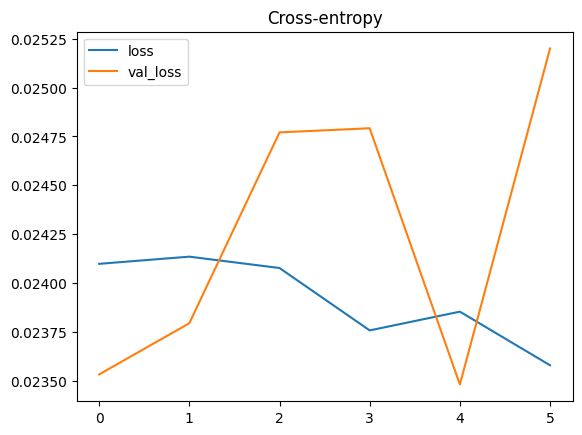

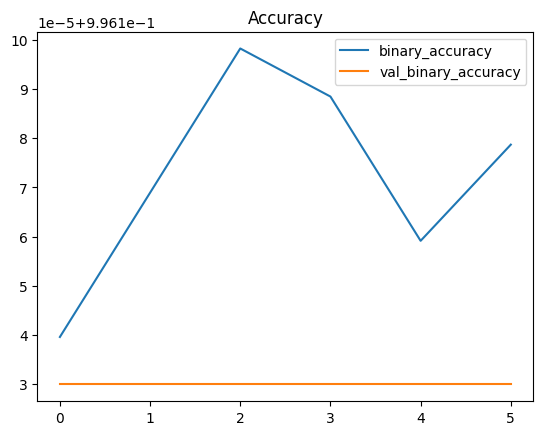

In [84]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [85]:
# preprocessing the testing data
testing_pp = preprocessor.fit_transform(testing)

In [86]:
predictions = binary_clf_model.predict(testing_pp)
# round predictions 
rounded = [round(x[0]) for x in predictions]

2843/2843 [==============================] - 7s 2ms/step


In [88]:
# preprocessing the testing data
testing_pp = preprocessor.fit_transform(testing)


predictions = binary_clf_model.predict(testing_pp)
# round predictions 
rounded = [round(x[0]) for x in predictions]

2843/2843 [==============================] - 7s 2ms/step


In [90]:
# add the predictions as new column to the test dataframe
test_data['Machine failure'] = rounded

In [91]:
test_data

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
0,136429,L50896,L,302.3,311.5,1499.0,38.0,60.0,0,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713.0,28.8,17.0,0,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525.0,37.7,96.0,0,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479.0,47.6,5.0,0,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515.0,41.3,114.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,227378,L51130,L,302.3,311.4,1484.0,40.4,15.0,0,0,0,0,0,0
90950,227379,L47783,L,297.9,309.8,1542.0,33.8,31.0,0,0,0,0,0,0
90951,227380,L48097,L,295.6,306.2,1501.0,41.4,187.0,0,0,0,0,0,0
90952,227381,L48969,L,298.1,307.8,1534.0,40.3,69.0,0,0,0,0,0,0


In [92]:
# create a submission file
test_data.to_csv('submission.csv', columns=['id','Machine failure'], index=False)

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, rounded)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()